In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
import category_encoders as ce


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns; sns.set()

In [2]:
def ordinal_encoding(df,col,mapping):
    ordinal_encoder = ce.OrdinalEncoder(cols = [col],return_df = True,mapping = [{'col':col,'mapping':mapping}])
    df_final = ordinal_encoder.fit_transform(df)
    return df_final

# Students

## Preprocessing

In [3]:
data_students = pd.read_csv('Datasets/students/StudentsPerformance.csv')

In [4]:
y = data_students['gender']

In [5]:
data_students = data_students.drop(columns=['gender', 'race/ethnicity'])

In [6]:
mapping_education = {"some college":0,"associate's degree":1,"high school":2,"some high school":3,"bachelor's degree":4, "master's degree":5}
mapping_lunch = {"standard":0,"free/reduced":1}
mapping_preparation = {"none":0,"completed":1}

In [7]:
data_students["lunch"] = ordinal_encoding(data_students['lunch'],"lunch",mapping_lunch)
data_students["test preparation course"] = ordinal_encoding(data_students['test preparation course'],"test preparation course",mapping_preparation)
data_students["parental level of education"] = ordinal_encoding(data_students['parental level of education'],"parental level of education",mapping_education)

In [8]:
scaler = StandardScaler()
columns = data_students.columns
data_students = scaler.fit_transform(data_students)
data_students = pd.DataFrame(data_students, columns = columns)

## Create NaN Values

In [9]:
# Generate NaN 
np.random.seed(1)
nan_students = data_students.mask(np.random.random(data_students.shape) < .1)

In [10]:
# Fill NAN values with median
mod_students = nan_students.fillna(nan_students.median())

In [11]:
# Drop rows with Nan values
nan_students = pd.concat([y, nan_students], axis = 1)
nan_students = nan_students.dropna()
y_nan = nan_students['gender']
nan_students = nan_students.drop(columns=['gender'])

## Split Data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data_students, y, test_size=0.33, random_state=0)
X_train_nan, X_test_nan, y_train_nan, y_test_nan = train_test_split(nan_students, y_nan, test_size=0.33, random_state=0)
X_train_mod, X_test_mod, y_train_mod, y_test_mod = train_test_split(mod_students, y, test_size=0.33, random_state=0)

## Models

In [14]:
def run_test(prob, data_students, medida='mean'):
    # Create Noise
    np.random.seed(42)
    nan_students = data_students.mask(np.random.random(data_students.shape) < prob)
    if medida == 'mean':
        mod_students = nan_students.fillna(nan_students.mean())
    elif medida == 'median':
        mod_students = nan_students.fillna(nan_students.median())
    nan_students = pd.concat([y, nan_students], axis = 1)
    nan_students = nan_students.dropna()
    y_nan = nan_students['gender']
    nan_students = nan_students.drop(columns=['gender'])
    
    # Split Data
    X_train_nan, X_test_nan, y_train_nan, y_test_nan = train_test_split(nan_students, y_nan, test_size=0.33, random_state=0)
    X_train_mod, X_test_mod, y_train_mod, y_test_mod = train_test_split(mod_students, y, test_size=0.33, random_state=0)

    # With Nan
    discriminative = LogisticRegression(random_state = 0)
    generative = GaussianNB()
    
    discriminative.fit(X_train_nan, y_train_nan)
    generative.fit(X_train_nan, y_train_nan)
    
    dis_nan = discriminative.score(X_test_nan, y_test_nan)
    mod_nan = generative.score(X_test_nan, y_test_nan)
    
    # Without Nan
    discriminative = LogisticRegression(random_state = 0)
    generative = GaussianNB()
    
    discriminative.fit(X_train_mod, y_train_mod)
    generative.fit(X_train_mod, y_train_mod)
    
    dis_mod = discriminative.score(X_train_mod, y_train_mod)
    gen_mod = generative.score(X_train_mod, y_train_mod)
    
    return (dis_mod-dis_nan, gen_mod-gen_nan)

In [15]:
def plot_test(x, dis, gen):
    figure(figsize=(15, 8), dpi=80)
    plt.plot(x, dis, label = 'disc')
    plt.plot(x, gen, label = 'gen')
    plt.legend()
    plt.show()

### With NaNs

In [16]:
discriminative = LogisticRegression(random_state = 0)
generative = GaussianNB()

In [17]:
discriminative.fit(X_train_nan, y_train_nan)
generative.fit(X_train_nan, y_train_nan)

GaussianNB()

In [18]:
dis_nan = discriminative.score(X_test_nan, y_test_nan)
gen_nan = generative.score(X_test_nan, y_test_nan)

### Without NaNs

In [19]:
discriminative = LogisticRegression(random_state = 0)
generative = GaussianNB()

In [20]:
discriminative.fit(X_train_mod, y_train_mod)
generative.fit(X_train_mod, y_train_mod)

GaussianNB()

In [21]:
dis_mod = discriminative.score(X_test_mod, y_test_mod)
gen_mod = generative.score(X_test_mod, y_test_mod)

In [22]:
print (f'Discriminativo con NaN: {dis_nan}\nDiscriminativo modificado: {dis_mod}\ndiff: {dis_mod-dis_nan}\n')
print (f'Generativo con NaN: {gen_nan}\nGenerativo modificado: {gen_mod}\ndiff: {gen_mod-gen_nan}')

Discriminativo con NaN: 0.8722222222222222
Discriminativo modificado: 0.8363636363636363
diff: -0.03585858585858592

Generativo con NaN: 0.7944444444444444
Generativo modificado: 0.696969696969697
diff: -0.09747474747474738


In [23]:
test_values = [.1, .2, .3, .35,  .4, .5]

In [24]:
values = [run_test(i, data_students, 'mean') for i in test_values]

In [25]:
gen = []
dis = []
for d, g in values:
    dis.append(d)
    gen.append(g)

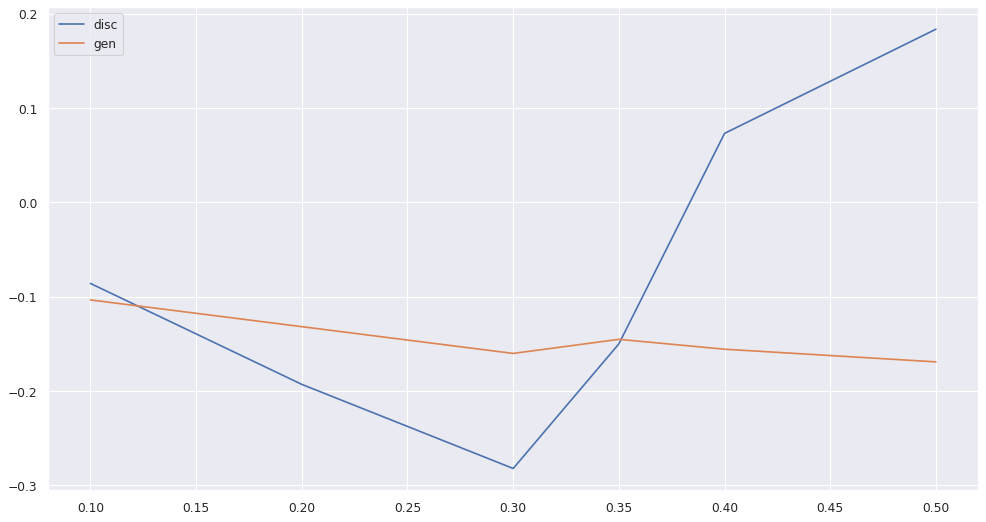

In [26]:
plot_test(test_values, dis, gen)

In [27]:
np.random.seed(1)
nan_students = data_students.mask(np.random.random(data_students.shape) < .35)

In [28]:
# Drop rows with Nan values
nan_students = pd.concat([y, nan_students], axis = 1)
nan_students = nan_students.dropna()
y_nan = nan_students['gender']
nan_students = nan_students.drop(columns=['gender'])

In [29]:
nan_students.shape

(79, 6)

In [30]:
values = [run_test(i, data_students, 'median') for i in test_values]

In [31]:
gen = []
dis = []
for d, g in values:
    dis.append(d)
    gen.append(g)

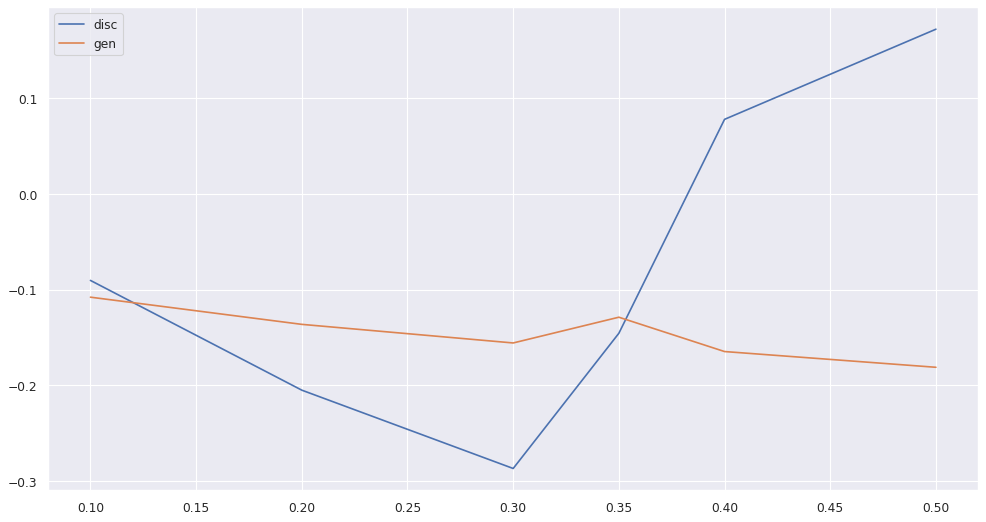

In [32]:
plot_test(test_values, dis, gen)